##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) and [predicting fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression) — we saw that the accuracy of our model on the validation data would peak after training for a number of epochs, and would then stagnate or start decreasing.

In other words, our model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what we really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the test data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.1.0


In [4]:
#!pip install -q git+https://github.com/tensorflow/docs
#!pip install git+https://github.com/tensorflow/docs


In [5]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [6]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [7]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


## The Higgs Dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11&#x202F;000&#x202F;000 examples, each with 28 features, and a binary class label.

https://www.tensorflow.org/datasets/catalog/higgs

In [8]:
#gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')
#gz = 'C:/Users/kevinm/Documents/SMU/MSDS7337_NaturalLanguageProcessing/Week11/HIGGS.csv.gz'
#gz = 'C:/Users/shayden/Downloads/HIGGS.csv.gz'
#gz = tf.keras.utils.get_file('HIGGS.csv.gz', '/home/jjschued/HIGGS.csv')

In [9]:
import os
proxy = 'http://proxy.rockwellcollins.com:9090'
os.environ['http_proxy'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [10]:
import pandas as pd
import requests
from io import StringIO

In [23]:
#https://drive.google.com/file/d/17vHho4WOidi1xsU5nuYIxvgaxKTK2L75/view?usp=sharing
file_id = '17vHho4WOidi1xsU5nuYIxvgaxKTK2L75'
#url_dataset = 'https://drive.google.com/uc?export=download&id=' + file_id
#url_dataset = '/user/jjschued/HIGGS.csv'
#url_dataset = 'https://drive.google.com/u/1/uc?export=download&confirm=cg02&id=17vHho4WOidi1xsU5nuYIxvgaxKTK2L75'
#url_dataset = "https://doc-0g-4c-docs.googleusercontent.com/docs/securesc/aplji487l37jpmjrtc3fc7mkdck4ah8r/qd2imheo9cvohf9r82e90395lm9o7bva/1595540025000/05402358165231425872/05402358165231425872/17vHho4WOidi1xsU5nuYIxvgaxKTK2L75?e=download&authuser=1"
#url = requests.get(url_dataset).text
#csv_raw = StringIO(url)
url_dataset = '/home/jjschued/HIGGS.csv'
#df = pd.read_csv('C:/Users/shayden/Downloads/HIGGS.csv.gz', compression = 'gzip', header = None)
#url_dataset = 'C:/Users/shayden/Downloads/HIGGS.csv'
#df = pd.read_csv(url_dataset, nrows=1000000)
df = pd.read_csv(url_dataset, nrows=11000)

In [24]:
url_dataset

'/home/jjschued/HIGGS.csv'

In [25]:
df

,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,...,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,1.0,0.767357,1.084947,0.299487,0.511042,-0.374340,0.774997,-0.218866,-0.547110,1.086538,...,1.377029,-1.557350,0.000000,1.077976,1.028331,0.984388,1.004476,0.925660,1.012436,1.057740
10996,0.0,0.306174,-1.808714,-1.240359,1.365489,-1.740858,1.695741,0.731754,0.156495,0.000000,...,1.232118,-0.143431,0.000000,0.886896,0.935988,0.973462,0.879262,0.605018,0.853274,1.018208
10997,1.0,0.794809,-0.059466,0.526425,0.736569,1.662992,0.614593,-1.320002,-0.025997,0.000000,...,-1.238036,-1.050715,3.101961,1.443730,1.199071,0.990352,0.697507,0.799412,1.002388,0.846745
10998,0.0,0.839097,0.202531,0.619642,0.497209,-1.177904,0.544788,1.262518,0.130439,0.000000,...,-1.053149,-0.947502,3.101961,0.806380,1.075156,0.987699,0.624265,0.887372,0.718604,0.641227


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   1.000000000000000000e+00    11000 non-null  float64
 1   8.692932128906250000e-01    11000 non-null  float64
 2   -6.350818276405334473e-01   11000 non-null  float64
 3   2.256902605295181274e-01    11000 non-null  float64
 4   3.274700641632080078e-01    11000 non-null  float64
 5   -6.899932026863098145e-01   11000 non-null  float64
 6   7.542022466659545898e-01    11000 non-null  float64
 7   -2.485731393098831177e-01   11000 non-null  float64
 8   -1.092063903808593750e+00   11000 non-null  float64
 9   0.000000000000000000e+00    11000 non-null  float64
 10  1.374992132186889648e+00    11000 non-null  float64
 11  -6.536741852760314941e-01   11000 non-null  float64
 12  9.303491115570068359e-01    11000 non-null  float64
 13  1.107436060905456543e+00    110

In [27]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

To keep this tutorial relatively short use just the first 1000 samples for validation, and the next 10 000 for training:

In [28]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data form the file on each epoch:

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only `layers.Dense` as a baseline, then create larger versions, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `optimizers.schedules` to reduce the learning rate over time:

In [29]:
dfx = df.rename(columns={x:y for x,y in zip(df.columns,range(0,len(df.columns)))})

In [30]:
dfx

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,1.0,0.767357,1.084947,0.299487,0.511042,-0.374340,0.774997,-0.218866,-0.547110,1.086538,...,1.377029,-1.557350,0.000000,1.077976,1.028331,0.984388,1.004476,0.925660,1.012436,1.057740
10996,0.0,0.306174,-1.808714,-1.240359,1.365489,-1.740858,1.695741,0.731754,0.156495,0.000000,...,1.232118,-0.143431,0.000000,0.886896,0.935988,0.973462,0.879262,0.605018,0.853274,1.018208
10997,1.0,0.794809,-0.059466,0.526425,0.736569,1.662992,0.614593,-1.320002,-0.025997,0.000000,...,-1.238036,-1.050715,3.101961,1.443730,1.199071,0.990352,0.697507,0.799412,1.002388,0.846745
10998,0.0,0.839097,0.202531,0.619642,0.497209,-1.177904,0.544788,1.262518,0.130439,0.000000,...,-1.053149,-0.947502,3.101961,0.806380,1.075156,0.987699,0.624265,0.887372,0.718604,0.641227


Case parms
* (Done) We selected a five-layer neural network with 300 hidden units in each layer,
* (Done) a learning rate of 0.05, and a weight decay coefficient of 1 × 10−5.
* (Done)Hidden layers have tanh activation function
* (Done)Gradient computations were made on mini-batches of size 100
* (Done)An additional boost in performance is obtained by using the dropout training algorithm, in which we stochastically drop neurons in the top hidden layer with 50% probability during training.
* (Done)Weights were initialized from a normal distribution with zero mean and standard deviation 0.1 in the first layer, 0.001 in the output layer, and 0.05 all other hidden layers.
* A momentum term increased linearly over the first 200 epochs from 0.9 to 0.99, at which point it remained constant.
* (Done)The learning rate decayed by a factor of 1.0000002 every batch update until it reached a minimum of 10^−6,

#### Dropout -
Dropout technique works by randomly reducing the number of interconnecting neurons within a neural network. At every training step, each neuron has a chance of being left out, or rather, dropped out of the collated contribution from connected neurons.
This technique minimizes overfitting because each neuron becomes independently sufficient, in the sense that the neurons within the layers learn weight values that are not based on the cooperation of its neighbouring neurons.

#### Momentum -
momentum helps SGD to navigate along the relevant directions and softens the oscillations in the irrelevant. It simply adds a fraction of the direction of the previous step to a current step. This achieves amplification of speed in the correct direction and softens oscillation in wrong directions. This fraction is usually in the (0, 1) range. It also makes sense to use adaptive momentum. In the beginning of learning a big momentum will only hinder your progress, so it makes sense to use something like 0.01 and once all the high gradients disappeared you can use a bigger momentum. There is one problem with momentum: when we are very close to the goal, our momentum in most of the cases is very high and it does not know that it should slow down. This can cause it to miss or oscillate around the minima

In [31]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [35]:
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.layers import LeakyReLU
#import pandas as pd
#import io
#import os
#import requests
#import numpy as np
#from sklearn import metrics
#from tensorflow.keras import optimizers

#Parms needed for case study  

#We selected a five-layer neural network with 300 hidden units in each layer,
#a learning rate of 0.05, and a weight decay coefficient of 1 × 10−5.
# Hidden layer have tanh activation function
#Gradient computations were made on mini-batches of size 100
#The learning rate decayed by a factor of 1.0000002 every batch update until it reached a minimum of 10^−6,

def define_predictor(n_input):
    
    optimizer = get_optimizer()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(300, kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None), input_dim = n_input, activation='tanh')) # Hidden 1
    model.add(layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(300,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh')) # Hidden 2
    model.add(tf.keras.layers.Dense(300,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh')) # Hidden 3
    model.add(tf.keras.layers.Dense(300,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh')) # Hidden 4
    model.add(tf.keras.layers.Dense(300,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh')) # Hidden 5
    model.add(tf.keras.layers.Dense(1,kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001, seed=None),activation='sigmoid')) # Output #1.2
    #model.add(tf.keras.layers.Dense(1,activation='softmax')) # Output
    sgd = tf.keras.optimizers.SGD(lr=.05, decay = 1.0000002, momentum=0.99)
    model.compile(loss='binary_crossentropy', optimizer=optimizer , metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

    
#setup scaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
dfx
X = dfx.loc[:, 1:28]
#X = dfx[features].copy()
Y = dfx[0].copy()
y = Y.values

# the cv=cvx parameter sets the grid search to split the training and testing data 10 times. 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn import metrics as mt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

Att_model = define_predictor(X_train.shape[1])
history = Att_model.fit(scaler.fit_transform(X_train),np.array(y_train), verbose=2, epochs=50, batch_size=100)

Train on 7700 samples
Epoch 1/50
7700/7700 - 2s - loss: 0.6665 - accuracy: 0.5943 - auc_2: 0.6255
Epoch 2/50
7700/7700 - 1s - loss: 0.6544 - accuracy: 0.6191 - auc_2: 0.6533
Epoch 3/50
7700/7700 - 1s - loss: 0.6526 - accuracy: 0.6194 - auc_2: 0.6586
Epoch 4/50
7700/7700 - 1s - loss: 0.6492 - accuracy: 0.6242 - auc_2: 0.6639
Epoch 5/50
7700/7700 - 1s - loss: 0.6466 - accuracy: 0.6256 - auc_2: 0.6685
Epoch 6/50
7700/7700 - 1s - loss: 0.6369 - accuracy: 0.6287 - auc_2: 0.6820
Epoch 7/50
7700/7700 - 1s - loss: 0.6312 - accuracy: 0.6462 - auc_2: 0.6942
Epoch 8/50
7700/7700 - 1s - loss: 0.6296 - accuracy: 0.6495 - auc_2: 0.6969
Epoch 9/50
7700/7700 - 1s - loss: 0.6265 - accuracy: 0.6532 - auc_2: 0.7020
Epoch 10/50
7700/7700 - 1s - loss: 0.6233 - accuracy: 0.6527 - auc_2: 0.7053
Epoch 11/50
7700/7700 - 1s - loss: 0.6183 - accuracy: 0.6577 - auc_2: 0.7134
Epoch 12/50
7700/7700 - 1s - loss: 0.6150 - accuracy: 0.6629 - auc_2: 0.7185
Epoch 13/50
7700/7700 - 1s - loss: 0.6104 - accuracy: 0.6686 - 

In [92]:
results = Att_model.evaluate(scaler.fit_transform(X_test),np.array(y_test), batch_size=100)

3300000/3300000 [==============================] - 387s 117us/sample - loss: 0.6368 - accuracy: 0.6351 - auc_2: 0.6810


In [93]:
results

[0.6367858866796349, 0.6351109, 0.68097997]

In [94]:
predictions = Att_model.predict(X_test)

In [95]:
predictions

array([[0.53745663],
       [0.47315976],
       [0.2537364 ],
       ...,
       [0.40031382],
       [0.43969497],
       [0.36572742]], dtype=float32)

In [96]:
preddf = pd.DataFrame(predictions)
preddf.head()

,0
0,0.537457
1,0.473160
2,0.253736
3,0.426297
4,0.443935


In [97]:
preddf['round'] = preddf.round(preddf[0])

In [98]:
preddf

,0,round
0,0.537457,1.0
1,0.473160,0.0
2,0.253736,0.0
3,0.426297,0.0
4,0.443935,0.0
...,...,...
3299995,0.369861,0.0
3299996,0.425234,0.0
3299997,0.400314,0.0
3299998,0.439695,0.0


In [99]:
yresultsround = preddf['round'].tolist()

In [100]:
yresultsround[2]

0.0

In [101]:
y_test.shape

(3300000,)

In [102]:
y_test[2]

0.0

In [103]:
ybinary = label_binarize(y_test, classes=[0,1])

In [104]:
y_score = label_binarize(yresultsround, classes=[0,1])

In [105]:

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

n_classes = ybinary.shape[1]
#X1_train, X1_test, y1_train, y1_test
#y_score = classifier.fit(X_train3, y_train3).decision_function(X_test3)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinary.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#Plot of a ROC curve for a specific class



Automatically created module for IPython interactive environment


In [106]:
fpr[0]

array([0.        , 0.16587329, 1.        ])

In [107]:
roc_auc

{0: 0.583418757106494, 'micro': 0.583418757106494}

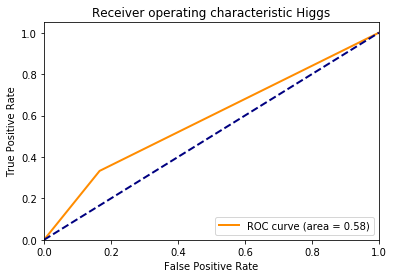

In [108]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Higgs')
plt.legend(loc="lower right")
plt.show()

In [109]:
Att_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 300)               8700      
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_14 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_15 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_16 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [110]:
history.history

{'loss': [0.6575804856194369,
  0.6498665150175226,
  0.6491678124157377,
  0.6487105784715035,
  0.6484905509586539,
  0.6483771005886071,
  0.6481777050707198,
  0.6480669391480594,
  0.6479537688507456,
  0.6478786802897714,
  0.647769174354559,
  0.6477800174997014,
  0.6476682366859828,
  0.6475936811962071,
  0.6476208858368728,
  0.6475229449407568,
  0.6474221309233635,
  0.6474460795156036,
  0.6473785711847662,
  0.6473424261474819,
  0.6472231196007564,
  0.6472462438763197,
  0.6472504043213023,
  0.6471769842672972,
  0.647210466591482,
  0.6471537504817934,
  0.6471439246124138,
  0.6471241563553063,
  0.647074049818501,
  0.6470876337968994,
  0.6470723407763895,
  0.6469288005318288,
  0.6470454698623203,
  0.6468924524914476,
  0.6469443892517938,
  0.6469954406249157,
  0.6468496953727445,
  0.6468145757987813,
  0.64687286761276,
  0.6468287678276792,
  0.6468787300589656,
  0.6467500197122916,
  0.6468645424590649,
  0.6467699600236781,
  0.6467824132101896,
  0.646

In [111]:
#%%time
#size_histories['Tiny3'], Tinypred3, Tinyvalres3 = compile_and_fit(tiny_model3, 'sizes/Tiny')

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

To open an embedded  TensorBoard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/sizes
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [40]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

In [41]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp91k2zj_4/tensorboard_logs/sizes/Tiny'

In [ ]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

## Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.